<a href="https://colab.research.google.com/github/pseudope/2021_F_Level2/blob/main/Sessions/20211027_Level2_1d_conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 20211027 (1D Convolution)

4기 Level 2 1D Convolution 자료입니다.

# Contents

1. Multi Kernel 1D Convolution
2. 의도 분류

In [ ]:
#!/usr/bin/env python3

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm

from sklearn import preprocessing
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense, Input, Flatten, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

# 1. Multi Kernel 1D Convoution

## Preparing Dataset

In [ ]:
### 데이터 로드

urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7f1904a79b00>)

In [ ]:
train_data = pd.read_table("dataset/ratings_train.txt")
test_data = pd.read_table("dataset/ratings_test.txt")

del train_data["id"]
del test_data["id"]

In [ ]:
print("훈련용 리뷰 개수 :", len(train_data))
train_data.head(10)

훈련용 리뷰 개수 : 150000


,document,label
0,아 더빙.. 진짜 짜증나네요 목소리,0
1,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,너무재밓었다그래서보는것을추천한다,0
3,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
5,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0
6,원작의 긴장감을 제대로 살려내지못했다.,0
7,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,0
8,액션이 없는데도 재미 있는 몇안되는 영화,1
9,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,1


In [ ]:
print("테스트용 리뷰 개수 :", len(test_data))
test_data.head(10)

테스트용 리뷰 개수 : 50000


,document,label
0,굳 ㅋ,1
1,GDNTOPCLASSINTHECLUB,0
2,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
5,"음악이 주가 된, 최고의 음악영화",1
6,진정한 쓰레기,0
7,"마치 미국애니에서 튀어나온듯한 창의력없는 로봇디자인부터가,고개를 젖게한다",0
8,갈수록 개판되가는 중국영화 유치하고 내용없음 폼잡다 끝남 말도안되는 무기에 유치한c...,0
9,"이별의 아픔뒤에 찾아오는 새로운 인연의 기쁨 But, 모든 사람이 그렇지는 않네..",1


## Preprocessing

In [ ]:
print(train_data['document'].nunique())   # 중복 데이터 발견
print(train_data['label'].nunique())

146182
2


### Train Data

In [ ]:
print(train_data.isnull().sum())

document    5
label       0
dtype: int64


In [ ]:
train_data.loc[train_data.document.isnull()]   # NaN 데이터 발견

,document,label
25857,NaN,1
55737,NaN,1
110014,NaN,0
126782,NaN,0
140721,NaN,0


In [ ]:
train_data = train_data.dropna(how = "any")
print(train_data.isnull().values.any())

False


총 train data의 수: 146182
   label  count
0      0  73342
1      1  72840


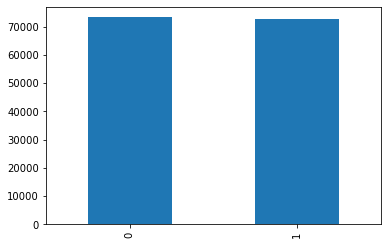

In [ ]:
train_data.drop_duplicates(subset=['document'], inplace=True)
print("총 train data의 수:", len(train_data))

train_data['label'].value_counts().plot(kind = 'bar')
print(train_data.groupby('label').size().reset_index(name = 'count'))

In [ ]:
train_data["document"] = train_data["document"].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data.head(10)

,document,label
0,아 더빙 진짜 짜증나네요 목소리,0
1,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,너무재밓었다그래서보는것을추천한다,0
3,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1
5,막 걸음마 뗀 세부터 초등학교 학년생인 살용영화ㅋㅋㅋ별반개도 아까움,0
6,원작의 긴장감을 제대로 살려내지못했다,0
7,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지정말 발로해도 그것보단 낫...,0
8,액션이 없는데도 재미 있는 몇안되는 영화,1
9,왜케 평점이 낮은건데 꽤 볼만한데 헐리우드식 화려함에만 너무 길들여져 있나,1


In [ ]:
### 빈칸을 NaN으로 변환

train_data["document"] = train_data["document"].str.replace("^ +", "")
train_data["document"].replace("", np.nan, inplace=True)
print(train_data.isnull().sum())

document    789
label         0
dtype: int64


In [ ]:
train_data.loc[train_data.document.isnull()]

,document,label
404,NaN,0
412,NaN,1
470,NaN,1
584,NaN,0
593,NaN,0
...,...,...
149309,NaN,1
149358,NaN,0
149364,NaN,1
149630,NaN,0


In [ ]:
train_data = train_data.dropna(how = "any")
print("총 train data의 수:", len(train_data))

총 train data의 수: 145393


### Test Data

In [ ]:
print(test_data.isnull().sum())

document    3
label       0
dtype: int64


In [ ]:
test_data.loc[test_data.document.isnull()]   # NaN 데이터 발견

,document,label
5746,NaN,1
7899,NaN,0
27097,NaN,1


In [ ]:
test_data = test_data.dropna(how = "any")
print(test_data.isnull().values.any())

False


총 test 데이터의 수: 145393
   label  count
0      0  24446
1      1  24711


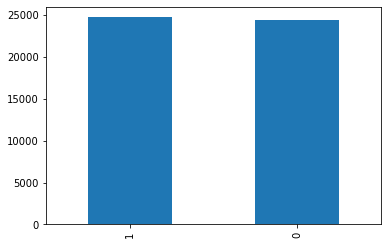

In [ ]:
test_data.drop_duplicates(subset=['document'], inplace=True)
print("총 test 데이터의 수:", len(train_data))

test_data['label'].value_counts().plot(kind = 'bar')
print(test_data.groupby('label').size().reset_index(name = 'count'))

In [ ]:
test_data["document"] = test_data["document"].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data.head(10)

,document,label
0,굳 ㅋ,1
1,,0
2,뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아,0
3,지루하지는 않은데 완전 막장임 돈주고 보기에는,0
4,만 아니었어도 별 다섯 개 줬을텐데 왜 로 나와서 제 심기를 불편하게 하죠,0
5,음악이 주가 된 최고의 음악영화,1
6,진정한 쓰레기,0
7,마치 미국애니에서 튀어나온듯한 창의력없는 로봇디자인부터가고개를 젖게한다,0
8,갈수록 개판되가는 중국영화 유치하고 내용없음 폼잡다 끝남 말도안되는 무기에 유치한남...,0
9,이별의 아픔뒤에 찾아오는 새로운 인연의 기쁨 모든 사람이 그렇지는 않네,1


In [ ]:
### 빈칸을 NaN으로 변환

test_data["document"] = test_data["document"].str.replace("^ +", "")
test_data["document"].replace("", np.nan, inplace=True)
print(test_data.isnull().sum())

document    305
label         0
dtype: int64


In [ ]:
test_data.loc[test_data.document.isnull()]

,document,label
1,NaN,0
116,NaN,1
254,NaN,0
468,NaN,0
504,NaN,0
...,...,...
49420,NaN,0
49459,NaN,1
49803,NaN,1
49871,NaN,0


In [ ]:
test_data = test_data.dropna(how = 'any')
print("총 test data의 수:", len(test_data))

총 test data의 수: 48852


## Tokenization

In [ ]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [ ]:
okt = Okt()

X_train = []

for sentence in tqdm(train_data["document"]):
    
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|██████████| 145393/145393 [12:55<00:00, 187.47it/s]


In [ ]:
print(X_train[:10])

[['아', '더빙', '진짜', '짜증나다', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'], ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다'], ['교도소', '이야기', '구먼', '솔직하다', '재미', '없다', '평점', '조정'], ['사이', '몬페', '그', '익살스럽다', '연기', '돋보이다', '영화', '스파이더맨', '에서', '늙다', '보이다', '커스틴', '던스트', '너무나도', '이쁘다', '보이다'], ['막', '걸음', '마', '떼다', '세', '부터', '초등학교', '학년', '생인', '살다', '영화', 'ㅋㅋㅋ', '별', '반개', '아깝다', '움'], ['원작', '긴장감', '을', '제대로', '살리다'], ['별', '반개', '아깝다', '욕', '나오다', '이응경', '길용우', '연', '기', '생활', '몇', '년', '인지', '정말', '발', '로', '해도', '그것', '보단', '낫다', '납치', '감금', '만', '반복', '반복', '드라마', '가족', '없다', '연기', '못', '사람', '만', '모', '엿', '네'], ['액션', '없다', '재미', '있다', '몇', '안되다', '영화'], ['왜케', '평점', '낮다', '꽤', '볼', '만', '데', '헐리우드', '식', '화려하다', '너무', '길들이다', '있다']]


In [ ]:
X_test = []

for sentence in tqdm(test_data["document"]):
    
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 48852/48852 [04:52<00:00, 167.13it/s]


In [ ]:
print(X_test[:10])

[['굳다', 'ㅋ'], ['뭐', '야', '평점', '나쁘다', '않다', '점', '짜다', '리', '더', '더욱', '아니다'], ['지루하다', '않다', '완전', '막장', '임', '돈', '주다', '보기', '에는'], ['만', '아니다', '별', '다섯', '개', '주다', '왜', '로', '나오다', '제', '심기', '불편하다'], ['음악', '주가', '되다', '최고', '음악', '영화'], ['진정하다', '쓰레기'], ['마치', '미국', '애니', '에서', '튀어나오다', '창의력', '없다', '로봇', '디자인', '부터가', '고개', '젖다'], ['갈수록', '개판', '되다', '중국영화', '유치하다', '내용', '없다', '폼', '잡다', '끝나다', '말', '안되다', '무기', '유치하다', '남무', '아', '그리다', '동사서독', '같다', '영화', '이건', '류', '아', '류작', '이다'], ['이별', '아픔', '뒤', '찾아오다', '새롭다', '인연', '기쁨', '모든', '사람', '그렇다', '않다'], ['괜찮다', '오랜', '만', '포켓몬스터', '잼밌', '어', '요']]


## Encoding

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
#print(tokenizer.word_index)

In [ ]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 43752
등장 빈도가 2번 이하인 희귀 단어의 수: 24337
단어 집합에서 희귀 단어의 비율: 55.62488571950996
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8715872104872904


In [ ]:
### 전체 단어 개수 중 빈도수 2이하인 단어는 제거
### 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 19416


In [ ]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
print(X_train[:10])
print(X_test[:10])

[[50, 454, 16, 260, 659], [933, 457, 41, 602, 1, 214, 1449, 24, 961, 675, 19], [386, 2444, 2315, 5671, 2, 222, 9], [6492, 105, 8118, 218, 56, 4, 26, 3603], [1023, 29, 9145, 24, 833, 1, 2579, 21, 1108, 240, 14243, 1076, 254, 240], [722, 5672, 980, 1387, 427, 143, 1692, 1626, 11560, 225, 1, 92, 126, 1081, 45, 245], [213, 314, 3, 324, 482], [126, 1081, 45, 332, 23, 9786, 14244, 298, 123, 1585, 368, 119, 226, 10, 797, 17, 579, 574, 518, 475, 3117, 8119, 14, 1388, 1388, 37, 285, 4, 24, 35, 40, 14, 703, 1072, 69], [94, 4, 56, 6, 368, 97, 1], [1535, 26, 201, 535, 82, 14, 392, 1439, 361, 666, 8, 5673, 6]]
[[746, 88], [59, 162, 26, 428, 19, 20, 295, 880, 46, 785, 18], [65, 19, 86, 337, 109, 104, 62, 149, 275], [14, 18, 126, 2216, 101, 62, 36, 17, 23, 194, 13761, 799], [208, 2918, 11, 28, 208, 1], [658, 67], [1012, 375, 319, 21, 4208, 7284, 4, 1423, 4080, 2088, 4956, 3606], [511, 1175, 11, 2641, 207, 58, 4, 3070, 663, 198, 43, 97, 2210, 207, 50, 384, 15297, 15, 1, 83, 364, 50, 2258, 5], [2645, 1

In [ ]:
y_train = np.array(train_data["label"])
y_test = np.array(test_data["label"])

In [ ]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [ ]:
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

145162
145162


/home/ubuntu/anaconda3/envs/psd/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


## Padding

리뷰의 최대 길이: 69
리뷰의 평균 길이: 10.812485361182679


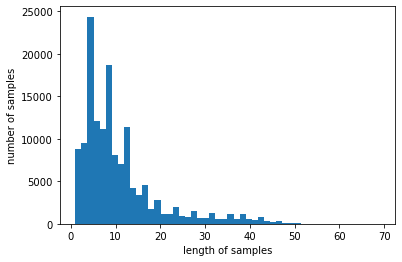

In [ ]:
print("리뷰의 최대 길이:", max(len(l) for l in X_train))
print("리뷰의 평균 길이:", sum(map(len, X_train)) / len(X_train))

plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel("length of samples")
plt.ylabel("number of samples")
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
    count = 0
    
    for sentence in nested_list:
        if(len(sentence) <= max_len):
            count = count + 1
            
    print("전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s"%(max_len, (count / len(nested_list))*100))

In [ ]:
max_len = 42
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 42 이하인 샘플의 비율: 99.02109367465314


In [ ]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

# Modeling

In [ ]:
### Hyperparameter

embedding_dim = 128
dropout_ratio = (0.5, 0.8)
num_filters = 128
hidden_units = 128

In [ ]:
model_input = Input(shape = (max_len,))

z = Embedding(vocab_size, embedding_dim, input_length = max_len, name="embedding")(model_input)
z = Dropout(dropout_ratio[0])(z)

In [ ]:
### 구조 상 Embedding 이후 세 갈래로 갈라지는 상황입니다.
### 각각의 Conv1D가 수행된 이후 concatenation으로 합쳐집니다.

conv_blocks = []

for sz in [3, 4, 5]:
    conv = Conv1D(filters = num_filters,
                         kernel_size = sz,
                         padding = "valid",
                         activation = "relu",
                         strides = 1)(z)
    conv = GlobalMaxPooling1D()(conv)
    conv_blocks.append(conv)

In [ ]:
z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
z = Dropout(dropout_ratio[1])(z)
z = Dense(hidden_units, activation="relu")(z)

model_output = Dense(1, activation="sigmoid")(z)

In [ ]:
model = Model(model_input, model_output)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc"])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 42, 128)      2485248     input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 42, 128)      0           embedding[0][0]                  
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 40, 128)      49280       dropout[0][0]                    
______________________________________________________________________________________________

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('CNN_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.fit(X_train, y_train, batch_size = 256, epochs=15, validation_split = 0.2, verbose=1, callbacks=[es, mc])

Epoch 1/15
454/454 [==============================] - ETA: 0s - loss: 0.4725 - acc: 0.7578
Epoch 00001: val_acc improved from -inf to 0.84070, saving model to CNN_model.h5
454/454 [==============================] - 9s 19ms/step - loss: 0.4725 - acc: 0.7578 - val_loss: 0.3705 - val_acc: 0.8407
Epoch 2/15
454/454 [==============================] - ETA: 0s - loss: 0.3532 - acc: 0.8475
Epoch 00002: val_acc improved from 0.84070 to 0.84704, saving model to CNN_model.h5
454/454 [==============================] - 8s 18ms/step - loss: 0.3532 - acc: 0.8475 - val_loss: 0.3575 - val_acc: 0.8470
Epoch 3/15
454/454 [==============================] - ETA: 0s - loss: 0.3177 - acc: 0.8668
Epoch 00003: val_acc did not improve from 0.84704
454/454 [==============================] - 8s 18ms/step - loss: 0.3177 - acc: 0.8668 - val_loss: 0.3579 - val_acc: 0.8455
Epoch 4/15
454/454 [==============================] - ETA: 0s - loss: 0.2936 - acc: 0.8782
Epoch 00004: val_acc did not improve from 0.84704
454/4

In [ ]:
loaded_model = load_model('CNN_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1527/1527 [==============================] - 4s 2ms/step - loss: 0.3615 - acc: 0.8429

 테스트 정확도: 0.8429


# 2. 의도 분류

## Preparing Dataset

In [ ]:
train_data = pd.read_csv("dataset/intent_train_data.csv")
test_data = pd.read_csv("dataset/intent_test_data.csv")

In [ ]:
intent_train = train_data["intent"].tolist()
label_train = train_data["label"].tolist()
intent_test = test_data["intent"].tolist()
label_test = test_data["label"].tolist()

In [ ]:
print("훈련용 문장의 수:", len(intent_train))
print("훈련용 레이블의 수:", len(label_train))
print("테스트용 문장의 수:", len(intent_test))
print("테스트용 레이블의 수:", len(label_test))

훈련용 문장의 수: 11784
훈련용 레이블의 수: 11784
테스트용 문장의 수: 600
테스트용 레이블의 수: 600


In [ ]:
print(intent_train[:5])
print(label_train[:5])

['add another song to the cita rom ntica playlist', 'add clem burke in my playlist pre party r b jams', 'add live from aragon ballroom to trapeo', 'add unite and win to my night out', 'add track to my digster future hits']
['AddToPlaylist', 'AddToPlaylist', 'AddToPlaylist', 'AddToPlaylist', 'AddToPlaylist']


<AxesSubplot:>

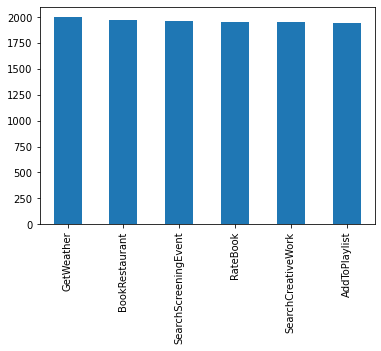

In [ ]:
train_data['label'].value_counts().plot(kind = 'bar')

## Encoding

### Label Encoding

In [ ]:
idx_encode = preprocessing.LabelEncoder()   # scikit-learn의 함수
idx_encode.fit(label_train)

label_train = idx_encode.transform(label_train)
label_test = idx_encode.transform(label_test)

label_idx = dict(zip(list(idx_encode.classes_), idx_encode.transform(list(idx_encode.classes_))))
print(label_idx)

{'AddToPlaylist': 0, 'BookRestaurant': 1, 'GetWeather': 2, 'RateBook': 3, 'SearchCreativeWork': 4, 'SearchScreeningEvent': 5}


### Sentence Encoding

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(intent_train)
sequences = tokenizer.texts_to_sequences(intent_train)
sequences[:5] # 상위 5개 샘플 출력

[[11, 191, 61, 4, 1, 4013, 1141, 1572, 15],
 [11, 2624, 1573, 3, 14, 15, 939, 82, 256, 188, 548],
 [11, 187, 42, 2625, 4014, 4, 1968],
 [11, 2626, 22, 2627, 4, 14, 192, 27],
 [11, 92, 4, 14, 651, 520, 195]]

In [ ]:
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print("단어 집합(Vocabulary)의 크기:", vocab_size)

단어 집합(Vocabulary)의 크기: 9870


문장의 최대 길이: 35
문장의 평균 길이: 9.364392396469789


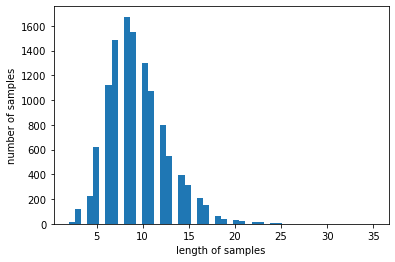

In [ ]:
print("문장의 최대 길이:", max(len(l) for l in sequences))
print("문장의 평균 길이:", sum(map(len, sequences))/len(sequences))

plt.hist([len(s) for s in sequences], bins=50)
plt.xlabel("length of samples")
plt.ylabel("number of samples")
plt.show()

In [ ]:
max_len = 35
intent_train = pad_sequences(sequences, maxlen = max_len)
label_train = to_categorical(np.asarray(label_train))

print("전체 데이터의 크기(shape):", intent_train.shape)
print("레이블 데이터의 크기(shape):", label_train.shape)

전체 데이터의 크기(shape): (11784, 35)
레이블 데이터의 크기(shape): (11784, 6)


## Shuffling

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(intent_train, label_train, test_size=0.1)

X_test = intent_test
y_test = label_test

In [ ]:
print("훈련 데이터의 크기(shape):", X_train.shape)
print("검증 데이터의 크기(shape):", X_val.shape)
print("훈련 데이터 레이블의 개수(shape):", y_train.shape)
print("검증 데이터 레이블의 개수(shape):", y_val.shape)
print("테스트 데이터의 개수:", len(X_test))
print("테스트 데이터 레이블의 개수:", len(y_test))

훈련 데이터의 크기(shape): (10605, 35)
검증 데이터의 크기(shape): (1179, 35)
훈련 데이터 레이블의 개수(shape): (10605, 6)
검증 데이터 레이블의 개수(shape): (1179, 6)
테스트 데이터의 개수: 600
테스트 데이터 레이블의 개수: 600


## Embedding

In [ ]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove*.zip

In [ ]:
embedding_dict = dict()

f = open(os.path.join("dataset/glove.6B.100d.txt"), encoding="utf-8")

for line in f:
    word_vector = line.split()
    word = word_vector[0]
    word_vector_arr = np.asarray(word_vector[1:], dtype="float32") # 100개의 값을 가지는 array로 변환
    embedding_dict[word] = word_vector_arr
    
f.close()

print("%s개의 Embedding vector가 있습니다." % len(embedding_dict))

400000개의 Embedding vector가 있습니다.


In [ ]:
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))

print(np.shape(embedding_matrix))

(9870, 100)


In [ ]:
for word, i in word_index.items():
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## Modeling

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense, Input, Flatten, Concatenate

In [ ]:
### Hyperparameter

embedding_dim = 100
dropout_ratio = (0.5, 0.8)
num_filters = 128
hidden_units = 128

kernel_sizes = [2, 3, 5]
num_filters = 512
dropout_ratio = 0.5

model_input = Input(shape=(max_len,))
output = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                      input_length=max_len, trainable=False)(model_input)

conv_blocks = []

for size in kernel_sizes:
    conv = Conv1D(filters=num_filters,
                         kernel_size=size,
                         padding="valid",
                         activation="relu",
                         strides=1)(output)
    conv = GlobalMaxPooling1D()(conv)
    conv_blocks.append(conv)

output = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
output = Dropout(dropout_ratio)(output)
model_output = Dense(len(label_idx), activation='softmax')(output)
model = Model(model_input, model_output)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 100)      987000      input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 34, 512)      102912      embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 33, 512)      154112      embedding[0][0]                  
____________________________________________________________________________________________

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('CNN_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.fit(X_train, y_train, batch_size = 256, epochs=15, validation_split = 0.2, verbose=1, callbacks=[es, mc])

Epoch 1/15
34/34 [==============================] - ETA: 0s - loss: 0.4370 - acc: 0.8601
Epoch 00001: val_acc improved from -inf to 0.96935, saving model to CNN_model.h5
34/34 [==============================] - 1s 37ms/step - loss: 0.4370 - acc: 0.8601 - val_loss: 0.1073 - val_acc: 0.9694
Epoch 2/15
30/34 [=========================>....] - ETA: 0s - loss: 0.0887 - acc: 0.9766
Epoch 00002: val_acc improved from 0.96935 to 0.97595, saving model to CNN_model.h5
34/34 [==============================] - 0s 14ms/step - loss: 0.0869 - acc: 0.9770 - val_loss: 0.0791 - val_acc: 0.9760
Epoch 3/15
32/34 [===========================>..] - ETA: 0s - loss: 0.0536 - acc: 0.9874
Epoch 00003: val_acc improved from 0.97595 to 0.97926, saving model to CNN_model.h5
34/34 [==============================] - 0s 12ms/step - loss: 0.0539 - acc: 0.9874 - val_loss: 0.0673 - val_acc: 0.9793
Epoch 4/15
31/34 [==========================>...] - ETA: 0s - loss: 0.0389 - acc: 0.9907
Epoch 00004: val_acc improved from 

In [ ]:
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=max_len)

y_predicted = model.predict(X_test)
y_predicted = y_predicted.argmax(axis=-1) # 예측된 정수 시퀀스로 변환

y_predicted = idx_encode.inverse_transform(y_predicted) # 정수 시퀀스를 레이블에 해당하는 텍스트 시퀀스로 변환
y_test = idx_encode.inverse_transform(y_test) # 정수 시퀀스를 레이블에 해당하는 텍스트 시퀀스로 변환

print("accuracy:", sum(y_predicted == y_test) / len(y_test))
print(classification_report(y_test, y_predicted))

accuracy: 0.9883333333333333
                      precision    recall  f1-score   support

       AddToPlaylist       1.00      1.00      1.00       100
      BookRestaurant       0.99      1.00      1.00       100
          GetWeather       0.99      0.99      0.99       100
            RateBook       1.00      1.00      1.00       100
  SearchCreativeWork       0.95      1.00      0.98       100
SearchScreeningEvent       1.00      0.94      0.97       100

            accuracy                           0.99       600
           macro avg       0.99      0.99      0.99       600
        weighted avg       0.99      0.99      0.99       600

